<h1><center><font size="6">Chat vs Chien</font></center></h1>


<center><img src="https://www.theladders.com/wp-content/uploads/dog-cat-190709-1000x563.jpg" width="900"></img></center>

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from glob import glob
import random
from PIL import Image
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
mixed_precision.set_global_policy("mixed_float16")  # Speed up training on GPU


TensorFlow Version: 2.18.0
Num GPUs Available: 1


# EDA

In [6]:
import os
import pandas as pd

# Dataset directory path
directory_path = "/kaggle/input/cats-dogs-dataset/CatDog2"

# Dictionary to store counts
data = []

# Iterate through each split (train, test, val)
for split in ['train', 'val']:
    split_path = os.path.join(directory_path, split)
    if os.path.exists(split_path):
        # Iterate through each class (chat, chien)
        for class_name in ['chat', 'chien']:
            class_path = os.path.join(split_path, class_name)
            if os.path.exists(class_path):
                # Count images
                image_count = len([f for f in os.listdir(class_path) 
                                 if os.path.isfile(os.path.join(class_path, f))])
                data.append({
                    'Split': split,
                    'Class': class_name,
                    'Class': 'Cat' if class_name == 'chat' else 'Dog',
                    'Image Count': image_count
                })

# Convert to DataFrame
df = pd.DataFrame(data)

# Pivot for better visualization
pivot_df = df.pivot_table(index=['Split', 'Class'], 
                         values='Image Count', 
                         aggfunc='sum').reset_index()

# Display results
print("Detailed Counts:")
print(df)
print("\nSummary View:")
print(pivot_df)

Detailed Counts:
   Split Class  Image Count
0  train   Cat          280
1  train   Dog          280
2    val   Cat           60
3    val   Dog           60

Summary View:
   Split Class  Image Count
0  train   Cat          280
1  train   Dog          280
2    val   Cat           60
3    val   Dog           60


## Summary Statistics

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic statistics
print(df.describe())


       Image Count
count     4.000000
mean    170.000000
std     127.017059
min      60.000000
25%      60.000000
50%     170.000000
75%     280.000000
max     280.000000


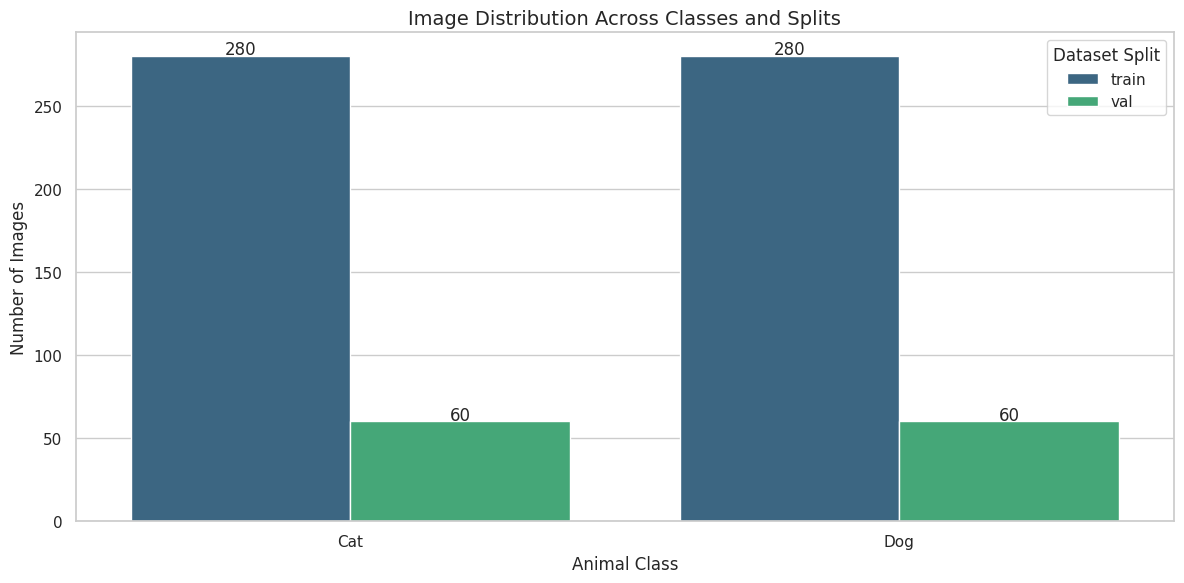

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set plot style and size
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create the bar plot with hue for splits
ax = sns.barplot(x="Class", y="Image Count", hue="Split", data=df, palette="viridis")

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

# Improve labels and title
plt.xlabel("Animal Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Image Distribution Across Classes and Splits", fontsize=14)
plt.legend(title='Dataset Split')

# Adjust layout and display plot
plt.tight_layout()
plt.show()

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import defaultdict

# Dataset directory path
directory_path = "/kaggle/input/cats-dogs-dataset/CatDog2"

# Initialize data collection
stats = {
    'extensions': defaultdict(int),
    'dimensions': [],
    'class_stats': defaultdict(lambda: {'count': 0, 'dimensions': []})
}

# Function to process images
def process_image(filepath, class_name, split):
    try:
        with Image.open(filepath) as img:
            width, height = img.size
            stats['dimensions'].append((width, height))
            stats['class_stats'][(split, class_name)]['dimensions'].append((width, height))
            stats['class_stats'][(split, class_name)]['count'] += 1
    except Exception as e:
        print(f"Error processing {filepath}: {str(e)}")

# Walk through directory structure
for split in ['train', 'val']:
    split_path = os.path.join(directory_path, split)
    if os.path.exists(split_path):
        for class_name in ['chat', 'chien']:
            class_path = os.path.join(split_path, class_name)
            if os.path.exists(class_path):
                for filename in os.listdir(class_path):
                    filepath = os.path.join(class_path, filename)
                    if os.path.isfile(filepath):
                        ext = os.path.splitext(filename)[1].lower()
                        stats['extensions'][ext] += 1
                        process_image(filepath, 'Cat' if class_name == 'chat' else 'Dog', split)

# Create DataFrames for visualization
ext_df = pd.DataFrame(list(stats['extensions'].items()), columns=['Extension', 'Count'])
dim_df = pd.DataFrame(stats['dimensions'], columns=['Width', 'Height'])
class_df = pd.DataFrame([
    {'Split': split, 'Class': cls, 'Count': data['count'], 
     'Avg Width': sum(w for w, h in data['dimensions'])/len(data['dimensions']),
     'Avg Height': sum(h for w, h in data['dimensions'])/len(data['dimensions'])}
    for (split, cls), data in stats['class_stats'].items()
])



/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


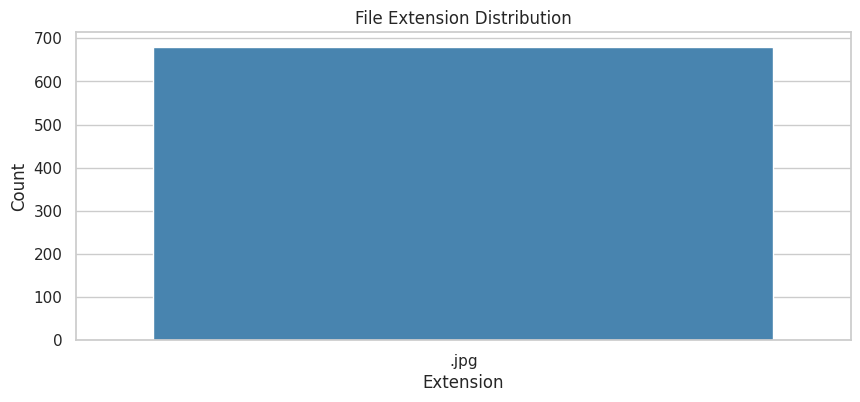

In [19]:
# Visualization 1: File Extensions
plt.figure(figsize=(10, 4))
sns.barplot(x='Extension', y='Count', data=ext_df, palette='Blues_d')
plt.title('File Extension Distribution')
plt.show()

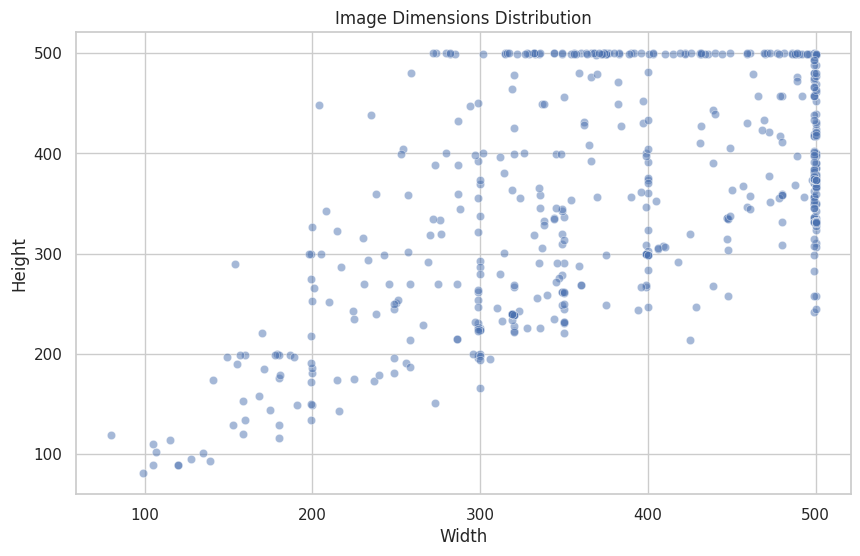

In [20]:
# Visualization 2: Image Dimensions Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Width', y='Height', data=dim_df, alpha=0.5)
plt.title('Image Dimensions Distribution')
plt.show()



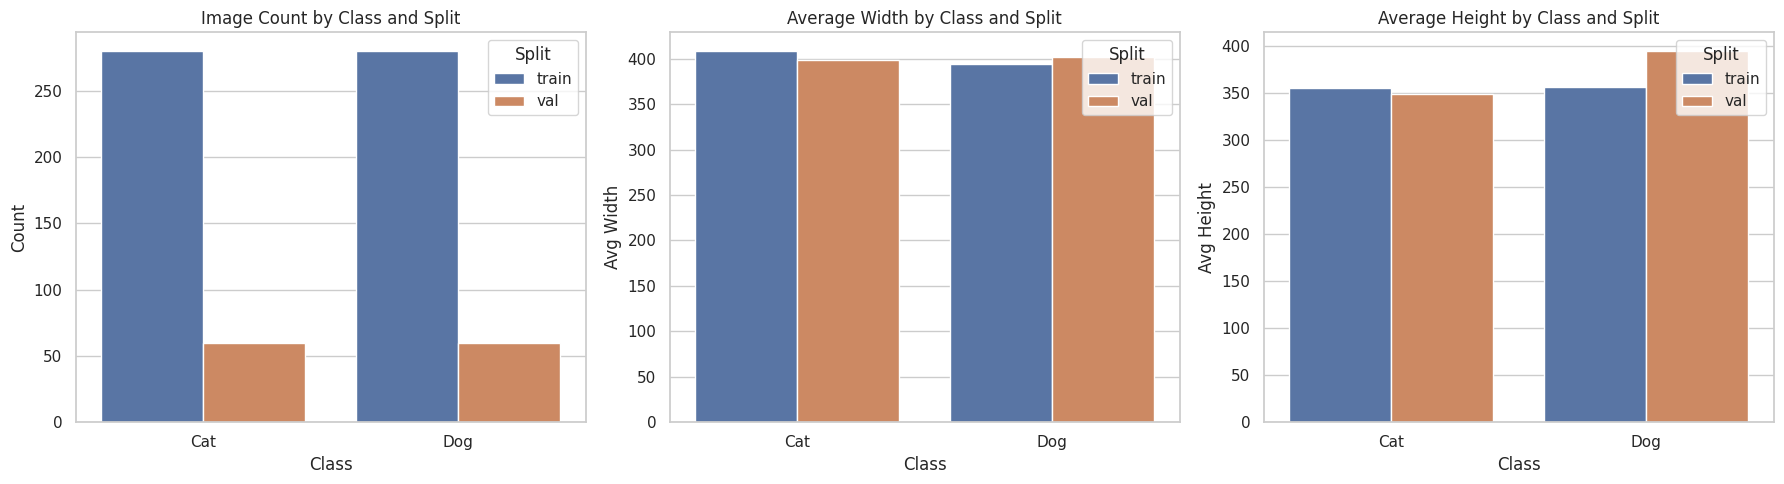

In [21]:
# Visualization 3: Class Statistics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(x='Class', y='Count', hue='Split', data=class_df, ax=axes[0])
axes[0].set_title('Image Count by Class and Split')

sns.barplot(x='Class', y='Avg Width', hue='Split', data=class_df, ax=axes[1])
axes[1].set_title('Average Width by Class and Split')

sns.barplot(x='Class', y='Avg Height', hue='Split', data=class_df, ax=axes[2])
axes[2].set_title('Average Height by Class and Split')

plt.tight_layout()
plt.show()



In [22]:
# Display summary tables
print("\n=== File Extensions Summary ===")
print(ext_df.sort_values('Count', ascending=False))

print("\n=== Image Dimensions Summary ===")
print(dim_df.describe())

print("\n=== Class Statistics ===")
print(class_df)


=== File Extensions Summary ===
  Extension  Count
0      .jpg    680

=== Image Dimensions Summary ===
            Width      Height
count  680.000000  680.000000
mean   401.338235  358.408824
std    108.073914   98.495788
min     80.000000   81.000000
25%    320.000000  300.000000
50%    433.000000  374.000000
75%    499.000000  419.250000
max    500.000000  500.000000

=== Class Statistics ===
   Split Class  Count   Avg Width  Avg Height
0  train   Cat    280  408.610714  354.914286
1  train   Dog    280  394.653571  356.300000
2    val   Cat     60  398.266667  348.700000
3    val   Dog     60  401.666667  394.266667


---
### **Analyse des Extensions de Fichiers**
- **Toutes les images sont en .jpg** (680 fichiers)  
  → Format uniforme, idéal pour le traitement  
  → Aucun problème de compatibilité à prévoir

### **Analyse des Dimensions des Images**
- **Grande variabilité** :
  - Largeur moyenne : 401px (±108)  
  - Hauteur moyenne : 358px (±98)  
  → Écart-type élevé indiquant des tailles hétérogènes

- **Plage extrême** :
  - Mini : 80x81px (risque de qualité insuffisante)  
  - Maxi : 500x500px (taille standard correcte)  
  → Nécessité potentielle de redimensionnement pour l'uniformisation

- **Dimensions médianes** :
  - 433x374px  
  → 50% des images sont plus grandes que cette taille

### **Répartition par Classe et Dataset**
**Jeu d'entraînement (train)** :
- **Chats** : 280 images (408x354px en moyenne)  
- **Chiens** : 280 images (394x356px en moyenne)  
→ **Équilibre parfait** entre classes  
→ Légère différence de taille moyenne (chats +14px en largeur)

**Jeu de validation (val)** :
- **Chats** : 60 images (398x348px)  
- **Chiens** : 60 images (401x394px)  
→ **Déséquilibre de hauteur** notable (+45px pour les chiens)  
→ À surveiller lors de l'évaluation des performances

### **Recommandations** :
1. **Pré-traitement conseillé** :
   - Redimensionnement à une taille fixe (ex: 400x400px)  
   - Recadrage centre pour conserver les ratios

2. **Vérification qualité** :
   - Contrôler manuellement les images <150px  
   - Vérifier le déséquilibre de hauteur en validation

3. **Augmentation de données** :
   - Pertinent pour les chiens du jeu de validation  
   - Rotation/zoom pour compenser la variabilité de taille
---

TRAIN - Cat: cat.15.jpg (405x353)
TRAIN - Cat: cat.360.jpg (499x375)
TRAIN - Cat: cat.292.jpg (499x419)
TRAIN - Cat: cat.53.jpg (492x457)
TRAIN - Dog: dog.0.jpg (499x375)
TRAIN - Dog: dog.89.jpg (500x374)
TRAIN - Dog: dog.262.jpg (400x299)
TRAIN - Dog: dog.305.jpg (480x359)
VAL - Cat: cat.123.jpg (345x272)
VAL - Cat: cat.57.jpg (335x291)
VAL - Cat: cat.13.jpg (499x315)
VAL - Cat: cat.256.jpg (230x316)
VAL - Dog: dog.352.jpg (396x500)
VAL - Dog: dog.253.jpg (500x418)
VAL - Dog: dog.169.jpg (210x252)
VAL - Dog: dog.57.jpg (302x400)


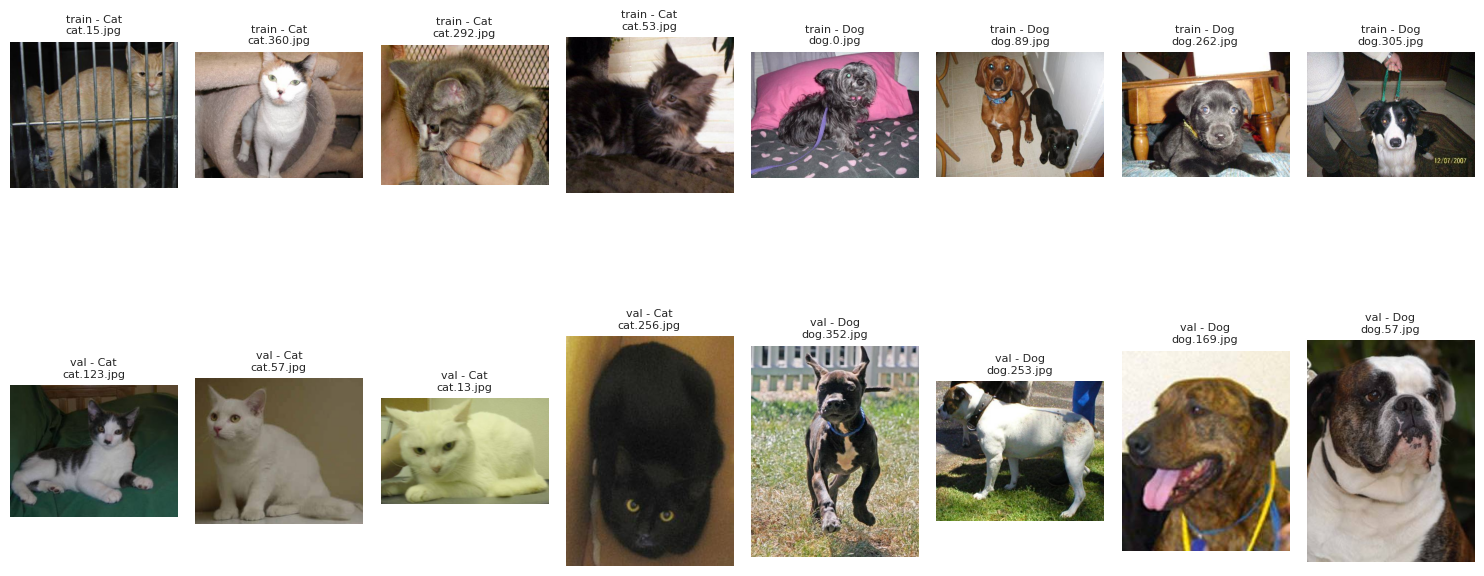

In [23]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

# Configuration
dataset_path = "/kaggle/input/cats-dogs-dataset/CatDog2"
splits = ['train', 'val']  # We'll show both validation and test
classes = {'chat': 'Cat', 'chien': 'Dog'}
samples_per_class = 4  # Number of samples to display per class

plt.figure(figsize=(15, 8))

for i, split in enumerate(splits, 1):
    for j, (class_fr, class_en) in enumerate(classes.items(), 1):
        # Get the path to images
        class_path = os.path.join(dataset_path, split, class_fr)
        if not os.path.exists(class_path):
            continue
            
        # Get random sample images
        all_images = os.listdir(class_path)
        sample_images = random.sample(all_images, min(samples_per_class, len(all_images)))
        
        # Display each sample
        for k, img_name in enumerate(sample_images, 1):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            
            # Create subplot
            plt.subplot(len(splits), samples_per_class*len(classes), (i-1)*samples_per_class*len(classes) + (j-1)*samples_per_class + k)
            plt.imshow(img)
            plt.title(f"{split} - {class_en}\n{img_name}", fontsize=8)
            plt.axis('off')
            
            # Print image info
            print(f"{split.upper()} - {class_en}: {img_name} ({img.size[0]}x{img.size[1]})")

plt.tight_layout()
plt.show()

---
1. Constat actuel
L'ensemble de données contient 680 images au format .jpg, avec des dimensions très variées :

Largeur moyenne : ~401 pixels (min : 80, max : 500)

Hauteur moyenne : ~358 pixels (min : 81, max : 500)

Les tailles sont hétérogènes, ce qui peut nuire à la performance d'un réseau de neurones convolutionnel (CNN) qui attend une taille fixe en entrée.

2. Problème
Les CNN nécessitent des images de dimensions constantes pour fonctionner efficacement. Si on ne traite pas cette disparité :

L'entraînement échouera ou sera inefficace.

Des distorsions peuvent apparaître si on redimensionne brutalement les images.

3. Solution proposée
Utiliser une approche de redimensionnement avec préservation du ratio d’aspect, suivie d’un remplissage (padding) pour uniformiser les dimensions.

🔹 Taille cible : 224x224 pixels
Taille standard pour la plupart des architectures CNN (ResNet, MobileNet, etc.)

Bon compromis entre qualité d’image et performance computationnelle.

🔹 Étapes à suivre :
Redimensionner chaque image de sorte que son plus grand côté corresponde à 224 pixels, tout en gardant le ratio largeur/hauteur.

Ajouter des bordures (pixels noirs ou blancs) sur les côtés restants pour obtenir une image finale carrée de 224x224.

Appliquer une augmentation de données pendant l’entraînement (rotations, flips, zooms, etc.) pour améliorer la généralisation.

---

# Model training

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetV2S  # Best balance of accuracy/size
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import tensorflow.keras.backend as K

def build_model():
    # base_model = EfficientNetV2S(
    #     weights='imagenet',
    #     include_top=False,
    #     input_shape=(384, 384, 3),
    #     pooling=None
    # )
    # base_model.trainable = False

    base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
    base_model.trainable = False  # freeze initial layers
    
    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # binaire : chat vs chien
    ])
    return model

model = build_model()

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation strategy for your 680-image dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation - Normalization only

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/cats-dogs-dataset/CatDog2/val',  # Your validation folder
    target_size=(384, 384),  # Must match training size
    batch_size=32,
    class_mode='binary',      # Binary classification
    classes=['chat', 'chien'], # Matches your French subfolders
    shuffle=False            # Important for validation metrics
)
# Flow from directory with your French folder names
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/cats-dogs-dataset/CatDog2/train',
    target_size=(384, 384),  # EffNetV2S optimal size
    batch_size=32,
    class_mode='binary',      # Cat/Dog is binary
    classes=['chat', 'chien'] # Match your French dirs
)

Found 120 images belonging to 2 classes.
Found 560 images belonging to 2 classes.


In [37]:
model = build_model()

# Custom optimizer configuration
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=1e-4,  # Lower than default for fine-tuning
    weight_decay=1e-5     # Regularization
)

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # learning rate plus bas
    loss='binary_crossentropy',
    metrics=['accuracy']
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)


callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
]


history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

NameError: name 'compute_class_weight' is not defined

In [39]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.applications import EfficientNetV2S
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1. Precision-optimized model
def build_model():
    base_model = EfficientNetV2S(
        weights='imagenet',
        include_top=False,
        input_shape=(300, 300, 3),
        pooling='avg'  # Better than GlobalAveragePooling2D for EfficientNet
    )
    
    # Strategic unfreezing
    base_model.trainable = False
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    inputs = tf.keras.Input(shape=(300, 300, 3))
    x = base_model(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='swish',  # Better than relu
                   kernel_regularizer=regularizers.l2(0.01))(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(inputs, outputs)

# 2. Enhanced data pipeline
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=35,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.25,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    brightness_range=[0.7, 1.3],
    channel_shift_range=50.0  # Color variation
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# 3. Generators with mixed precision
target_size = (300, 300)
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/cats-dogs-dataset/CatDog2/train',
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    classes=['chat', 'chien']
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/cats-dogs-dataset/CatDog2/val',
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    classes=['chat', 'chien']
)

# 4. Advanced class weighting
train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = {0: class_weights[0]*1.1,  # Extra weight for cats
                     1: class_weights[1]}

# 5. Optimized training setup
model = build_model()

# Cosine decay LR schedule
initial_lr = 1e-3
lr_schedule = optimizers.schedules.CosineDecay(
    initial_lr,
    decay_steps=len(train_generator)*20  # Full cosine cycle
)

optimizer = optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4
)

# Mixed precision policy
tf.keras.mixed_precision.set_global_policy('mixed_float16')
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc', curve='PR'),  # Precision-Recall AUC
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# 6. Enhanced callbacks (fixed .keras extension)
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=15,
        mode='max',
        restore_best_weights=True,
        min_delta=0.005
    ),
    callbacks.ModelCheckpoint(
        'best_model.keras',  # Fixed extension
        monitor='val_auc',
        save_best_only=True,
        mode='max'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        cooldown=2
    ),
    callbacks.TensorBoard(
        log_dir='logs',
        histogram_freq=1,
        profile_batch=(10, 20)
    )
]

# 7. Training with validation every 2 steps
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    validation_freq=2,  # Faster training
    callbacks=callbacks,
    class_weight=class_weight_dict
)

# 8. Post-training unfreezing
for layer in model.layers[1].layers[-40:]:  # Unfreeze more layers
    layer.trainable = True
    
model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='binary_crossentropy'
)

history_finetune = model.fit(
    train_generator,
    epochs=20,
    initial_epoch=100,
    validation_data=val_generator,
    callbacks=callbacks
)

Found 560 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
E0000 00:00:1745428745.515329     137 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745428745.742094     137 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 6/18 ━━━━━━━━━━━━━━━━━━━━ 7s 584ms/step - accuracy: 0.5232 - auc: 0.5764 - loss: 5.2739 - precision: 0.5111 - recall: 0.4608

E0000 00:00:1745428782.870862     136 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745428783.094356     136 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5403 - auc: 0.5411 - loss: 5.3495 - precision: 0.5305 - recall: 0.4853

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,auc,loss,precision,recall
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,auc,loss,precision,recall,learning_rate.
  callback.on_epoch_end(epoch, logs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.5412 - auc: 0.5411 - loss: 5.3426 - precision: 0.5325 - recall: 0.4849 - learning_rate: 9.9384e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.5791 - auc: 0.5983 - loss: 4.4993 - precision: 0.6102 - recall: 0.6171

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5790 - auc: 0.5976 - loss: 4.4922 - precision: 0.6082 - recall: 0.6160 - val_accuracy: 0.4500 - val_auc: 0.4006 - val_loss: 3.8679 - val_precision: 0.4634 - val_recall: 0.6333 - learning_rate: 9.7553e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 826ms/step - accuracy: 0.5220 - auc: 0.5608 - loss: 4.0663 - precision: 0.5497 - recall: 0.4643 - learning_rate: 9.4550e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 930ms/step - accuracy: 0.5329 - auc: 0.5623 - loss: 3.6238 - precision: 0.5474 - recall: 0.4824 - val_accuracy: 0.5083 - val_auc: 0.6625 - val_loss: 3.1106 - val_precision: 0.5048 - val_recall: 0.8833 - learning_rate: 9.0451e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 832ms/step - accuracy: 0.5782 - auc: 0.6411 - loss: 3.1951 - precision: 0.6403 - recall: 0.4987 - learning_rate: 8.5355e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 944ms/step - accuracy: 0.5809 - auc: 0.6230 - loss: 2.8747 - precision: 0.6085 - recall: 0.482

KeyboardInterrupt: 

In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.applications import EfficientNetV2B0  # Smaller variant

# 1. Reset everything and rebuild
tf.keras.backend.clear_session()

# 2. Revised Model Architecture
def build_fixed_model():
    base_model = EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=(256, 256, 3)  # Reduced resolution
    )
    
    # Gradual Unfreezing Strategy
    base_model.trainable = False
    for layer in base_model.layers[-15:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    inputs = tf.keras.Input(shape=(256, 256, 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(inputs, outputs)

# 3. Conservative Data Augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

# 4. Reset Generators with Smaller Batches
BATCH_SIZE = 16  # Reduced from 32
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/cats-dogs-dataset/CatDog2/train',
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# 5. New Optimizer Configuration
optimizer = optimizers.Adam(
    learning_rate=1e-3,  # Higher initial LR
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

model = build_fixed_model()
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 6. Simplified Callbacks
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        min_delta=0.01,
        mode='max'
    ),
    callbacks.ModelCheckpoint(
        'fixed_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
]

# 7. Initial Training Phase
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

# 8. Phase 2: Fine-Tuning
if history.epoch[-1] >= 10:  # Only if first phase completed
    for layer in model.layers[1].layers[-30:]:
        layer.trainable = True
    
    model.compile(
        optimizer=optimizers.Adam(1e-5),  # Very low LR
        loss='binary_crossentropy'
    )
    
    history = model.fit(
        train_generator,
        epochs=50,
        initial_epoch=30,
        validation_data=val_generator,
        callbacks=callbacks
    )

Found 560 images belonging to 2 classes.
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


E0000 00:00:1745429912.382948     136 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745429912.587795     136 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.4983 - loss: 0.7145

ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 300, 300, 3)

Found 560 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 122 images belonging to 2 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 10, 10, 1280)        │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,501,089 (78.21 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 20,334,176 (77.57 MB)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745445059.077578     116 service.cc:148] XLA service 0x7a25b8001660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745445059.078387     116 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745445063.414314     116 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745445088.852739     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 - 133s - 7s/step - accuracy: 0.5429 - loss: 0.9151 - val_accuracy: 0.5417 - val_loss: 0.6806 - learning_rate: 1.0000e-04
Epoch 2/10
18/18 - 14s - 786ms/step - accuracy: 0.5429 - loss: 0.8304 - val_accuracy: 0.5083 - val_loss: 0.6841 - learning_rate: 1.0000e-04
Epoch 3/10
18/18 - 14s - 791ms/step - accuracy: 0.5339 - loss: 0.8634 - val_accuracy: 0.4833 - val_loss: 0.6907 - learning_rate: 1.0000e-04
Epoch 4/10
18/18 - 15s - 808ms/step - accuracy: 0.5482 - loss: 0.8084 - val_accuracy: 0.5000 - val_loss: 0.6976 - learning_rate: 3.0000e-05
Epoch 5/10
18/18 - 15s - 812ms/step - accuracy: 0.5732 - loss: 0.7728 - val_accuracy: 0.5000 - val_loss: 0.7045 - learning_rate: 3.0000e-05
Epoch 6/10
18/18 - 15s - 816ms/step - accuracy: 0.5750 - loss: 0.7835 - val_accuracy: 0.5000 - val_loss: 0.7125 - learning_rate: 9.0000e-06
Epoch 1/10


E0000 00:00:1745445389.372311     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745445389.571987     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745445390.142553     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745445390.353917     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745445390.978397     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

18/18 - 320s - 18s/step - accuracy: 0.5375 - loss: 0.8866 - val_accuracy: 0.5000 - val_loss: 0.7101 - learning_rate: 1.0000e-05
Epoch 2/10
18/18 - 16s - 915ms/step - accuracy: 0.6554 - loss: 0.6620 - val_accuracy: 0.5000 - val_loss: 0.7354 - learning_rate: 1.0000e-05
Epoch 3/10
18/18 - 20s - 1s/step - accuracy: 0.6946 - loss: 0.6192 - val_accuracy: 0.5750 - val_loss: 0.6649 - learning_rate: 1.0000e-05
Epoch 4/10
18/18 - 19s - 1s/step - accuracy: 0.7679 - loss: 0.4781 - val_accuracy: 0.7417 - val_loss: 0.5448 - learning_rate: 1.0000e-05
Epoch 5/10
18/18 - 19s - 1s/step - accuracy: 0.8232 - loss: 0.4118 - val_accuracy: 0.8250 - val_loss: 0.4496 - learning_rate: 1.0000e-05
Epoch 6/10
18/18 - 20s - 1s/step - accuracy: 0.8089 - loss: 0.4046 - val_accuracy: 0.8583 - val_loss: 0.4085 - learning_rate: 1.0000e-05
Epoch 7/10
18/18 - 20s - 1s/step - accuracy: 0.8607 - loss: 0.3318 - val_accuracy: 0.8833 - val_loss: 0.3645 - learning_rate: 1.0000e-05
Epoch 8/10
18/18 - 19s - 1s/step - accuracy: 0.

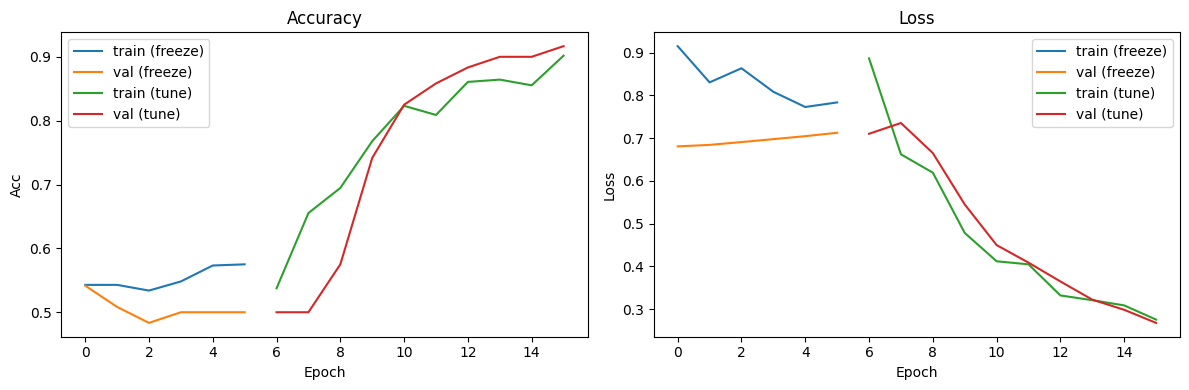


Classification Report:
              precision    recall  f1-score   support

           0     0.9574    0.7377    0.8333        61
           1     0.7867    0.9672    0.8676        61

    accuracy                         0.8525       122
   macro avg     0.8721    0.8525    0.8505       122
weighted avg     0.8721    0.8525    0.8505       122



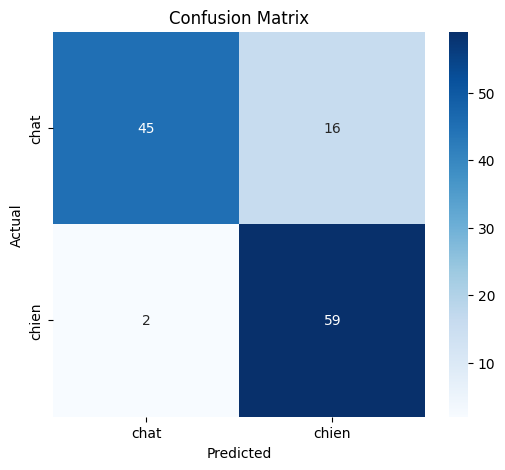

Most frequent mistake (actual→pred): [((0, 1), 16)]


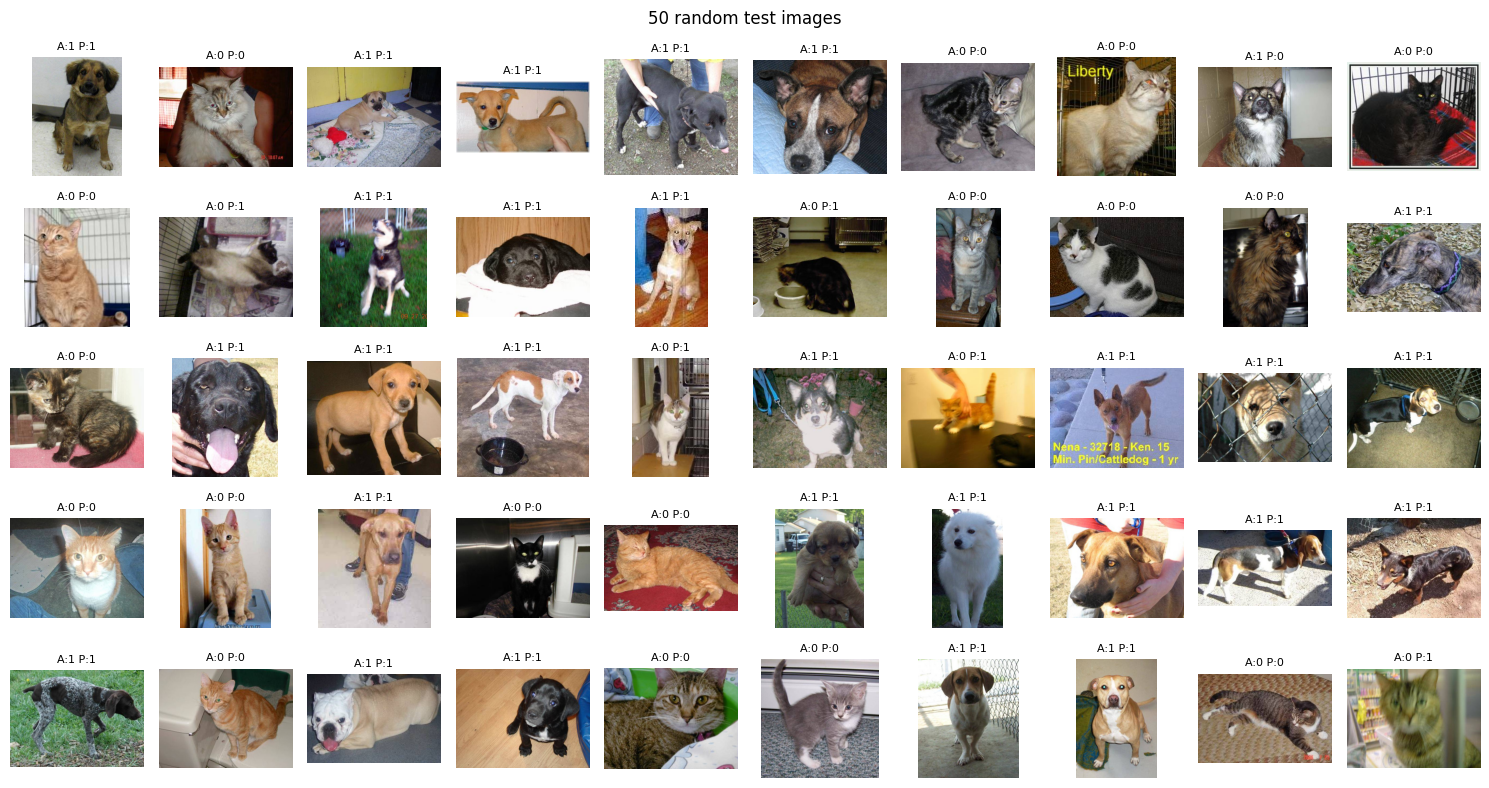

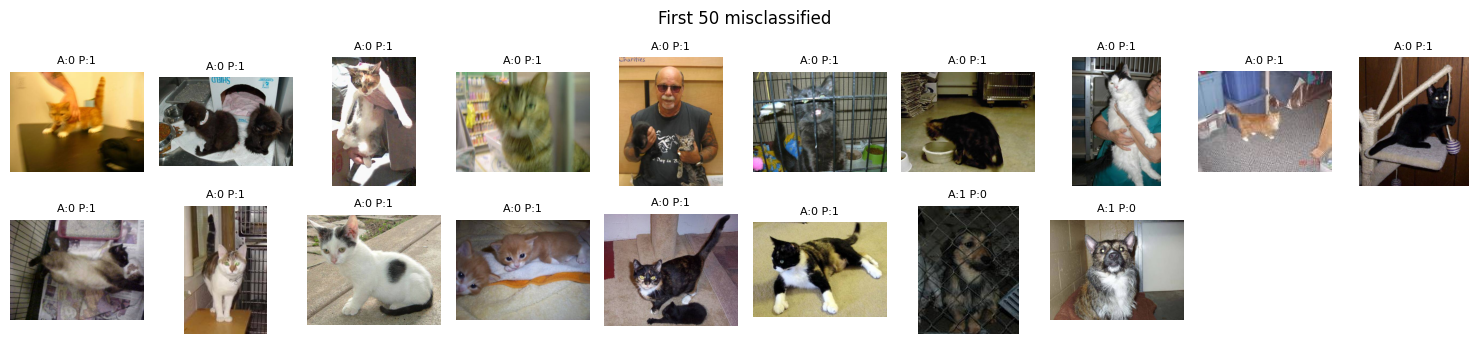

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, BatchNormalization,
    Dropout, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# ─── 1. Dataset paths & hyperparameters ────────────────────────────────────
BASE_DIR   = "/kaggle/input/cats-dogs-dataset/CatDog2"    # <-- adjust if needed
TRAIN_DIR  = os.path.join(BASE_DIR, "train")
VAL_DIR    = os.path.join(BASE_DIR, "val")
TEST_DIR   = os.path.join(BASE_DIR, "test")

IMAGE_SIZE    = (300, 300)
BATCH_SIZE    = 32
SEED          = 42
EPOCHS_FREEZE = 10
EPOCHS_TUNE   = 10

# ─── 2. Data generators ────────────────────────────────────────────────────
train_gen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255.)

train_ds = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=SEED
)
val_ds = val_gen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=SEED
)
test_ds = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# ─── 3. Build EfficientNetV2S model ────────────────────────────────────────
base_model = EfficientNetV2S(
    input_shape=(*IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze at first

inputs = Input(shape=(*IMAGE_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

# ─── 4. Callbacks ─────────────────────────────────────────────────────────
callbacks = [
    EarlyStopping(  monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2),
    ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)
]


# ─── 5. Train (base frozen) ────────────────────────────────────────────────
history_freeze = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FREEZE,
    callbacks=callbacks,
    verbose=2
)

# ─── 6. Fine-tune (unfreeze & lower LR) ────────────────────────────────────
base_model.trainable = True
# Optionally freeze all but last N layers:
# for layer in base_model.layers[:-50]:
#     layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_tune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_TUNE,
    callbacks=callbacks,
    verbose=2
)

# ─── 7. Evaluate on test set ───────────────────────────────────────────────
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss:     {test_loss:.4f}")

# ─── 8. Plot learning curves ───────────────────────────────────────────────
def plot_curves(h1, h2=None):
    plt.figure(figsize=(12,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(h1.history['accuracy'],    label='train (freeze)')
    plt.plot(h1.history['val_accuracy'],label='val (freeze)')
    if h2:
        epochs2 = range(len(h1.history['accuracy']), len(h1.history['accuracy'])+len(h2.history['accuracy']))
        plt.plot(epochs2, h2.history['accuracy'],    label='train (tune)')
        plt.plot(epochs2, h2.history['val_accuracy'],label='val (tune)')
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(h1.history['loss'],    label='train (freeze)')
    plt.plot(h1.history['val_loss'],label='val (freeze)')
    if h2:
        plt.plot(epochs2, h2.history['loss'],    label='train (tune)')
        plt.plot(epochs2, h2.history['val_loss'],label='val (tune)')
    plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.tight_layout()
    plt.show()

plot_curves(history_freeze, history_tune)

# ─── 9. Predictions & metrics ─────────────────────────────────────────────
# True & predicted
y_true       = test_ds.classes
y_pred_prob  = model.predict(test_ds, verbose=0).ravel()
y_pred       = (y_pred_prob >= 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_ds.class_indices,
            yticklabels=test_ds.class_indices)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

# Most frequent error
errors = [(a,p) for a,p in zip(y_true, y_pred) if a!=p]
print("Most frequent mistake (actual→pred):", Counter(errors).most_common(1))

# ─── 10. Show random + misclassified images ───────────────────────────────
# A) 50 random samples
plt.figure(figsize=(15,8))
idxs = random.sample(range(len(y_true)), 50)
for i, idx in enumerate(idxs):
    img = plt.imread(test_ds.filepaths[idx])
    plt.subplot(5,10,i+1)
    plt.imshow(img)
    plt.title(f"A:{y_true[idx]} P:{y_pred[idx]}", fontsize=8)
    plt.axis('off')
plt.suptitle("50 random test images"); plt.tight_layout(); plt.show()

# B) First 50 misclassified
mis = [i for i,(a,p) in enumerate(zip(y_true,y_pred)) if a!=p]
plt.figure(figsize=(15,8))
for i, idx in enumerate(mis[:50]):
    img = plt.imread(test_ds.filepaths[idx])
    plt.subplot(5,10,i+1)
    plt.imshow(img)
    plt.title(f"A:{y_true[idx]} P:{y_pred[idx]}", fontsize=8)
    plt.axis('off')
plt.suptitle("First 50 misclassified"); plt.tight_layout(); plt.show()


In [4]:
pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os, random, math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow_addons.optimizers import AdamW
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# ─── 0. Paths & params ─────────────────────────────────────────────────────
BASE_DIR   = "/kaggle/input/cats-dogs-dataset/CatDog2"
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 16       # smaller batches -> more gradient steps on small data
SEED       = 42

# ─── 1. Build tf.data pipelines ─────────────────────────────────────────────
def make_datasets():
    # load_dir: train, val, test
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(BASE_DIR, "train"),
        labels="inferred", label_mode="binary",
        image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
        seed=SEED, shuffle=True
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(BASE_DIR, "val"),
        labels="inferred", label_mode="binary",
        image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
        seed=SEED, shuffle=False
    )
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(BASE_DIR, "test"),
        labels="inferred", label_mode="binary",
        image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
        seed=SEED, shuffle=False
    )
    # Prefetch for performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.prefetch(AUTOTUNE)
    val_ds   = val_ds.prefetch(AUTOTUNE)
    test_ds  = test_ds.prefetch(AUTOTUNE)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = make_datasets()

# ─── 2. Data Augmentation & Preprocessing ────────────────────────────────────
augmenter = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="augmentation")

preprocess = tf.keras.applications.efficientnet_v2.preprocess_input

def preprocess_batch(images, labels):
    images = augmenter(images)
    images = preprocess(images)
    return images, labels

train_ds = train_ds.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(lambda x,y: (preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = test_ds.map(lambda x,y: (preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# ─── 3. Build Model ──────────────────────────────────────────────────────────
base = tf.keras.applications.EfficientNetV2S(
    input_shape=(*IMAGE_SIZE, 3),
    include_top=False, weights="imagenet"
)
base.trainable = False

inputs = layers.Input(shape=(*IMAGE_SIZE,3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu",
                kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs, name="EffNetV2S_CatsDogs")
model.summary()

# ─── 4. Compile & Train (Frozen Backbone) ──────────────────────────────────
freeze_epochs = 20
lr_freeze = 3e-4

model.compile(
    optimizer=AdamW(learning_rate=lr_freeze, weight_decay=1e-5),
    loss=SigmoidFocalCrossEntropy(alpha=0.25, gamma=2.0),
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)
]

history_freeze = model.fit(
    train_ds, validation_data=val_ds,
    epochs=freeze_epochs, callbacks=callbacks, verbose=2
)

# ─── 5. Fine-tune (Unfreeze & CosineDecay) ─────────────────────────────────
# Unfreeze last 30% of layers
total_layers = len(base.layers)
freeze_until = int(total_layers * 0.7)
for layer in base.layers[:freeze_until]:
    layer.trainable = False
for layer in base.layers[freeze_until:]:
    layer.trainable = True

# Cosine decay schedule
total_tune_epochs = 30
init_lr = 1e-5
lr_schedule = tf.keras.experimental.CosineDecay(
    init_lr, decay_steps=total_tune_epochs
)

model.compile(
    optimizer=AdamW(learning_rate=lr_schedule, weight_decay=1e-6),
    loss=SigmoidFocalCrossEntropy(alpha=0.25, gamma=2.0),
    metrics=["accuracy"]
)

history_tune = model.fit(
    train_ds, validation_data=val_ds,
    epochs=freeze_epochs + total_tune_epochs,
    initial_epoch=history_freeze.epoch[-1]+1,
    callbacks=callbacks, verbose=2
)

# ─── 6. Evaluate ───────────────────────────────────────────────────────────
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\n▶ Test Accuracy: {test_acc*100:.2f}%")
print(f"▶ Test Loss:     {test_loss:.4f}")

# ─── 7. Learning Curves ────────────────────────────────────────────────────
def plot_history(h1, h2):
    plt.figure(figsize=(12,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(h1.history["accuracy"], label="train (freeze)")
    plt.plot(h1.history["val_accuracy"],label="val (freeze)")
    plt.plot(h2.history["accuracy"], label="train (tune)")
    plt.plot(h2.history["val_accuracy"],label="val (tune)")
    plt.title("Accuracy"); plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(h1.history["loss"], label="train (freeze)")
    plt.plot(h1.history["val_loss"],label="val (freeze)")
    plt.plot(h2.history["loss"], label="train (tune)")
    plt.plot(h2.history["val_loss"],label="val (tune)")
    plt.title("Loss"); plt.legend()

    plt.tight_layout(); plt.show()

plot_history(history_freeze, history_tune)

# ─── 8. Predictions & Metrics ─────────────────────────────────────────────
# Gather true & predicted
y_true, y_pred = [], []
filepaths = []
for images, labels in test_ds.unbatch().batch(1):
    pred = model(images, training=False).numpy().ravel()[0]
    y_true.append(int(labels.numpy()[0]))
    y_pred.append(int(pred > 0.5))

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["chat","chien"],
            yticklabels=["chat","chien"])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

# Most frequent error
errors = [(a, p) for a, p in zip(y_true, y_pred) if a!=p]
print("Most frequent mistake (actual→pred):", Counter(errors).most_common(1))

# ─── 9. Visualize Random & Misclassified ─────────────────────────────────
# Need a flat list of filepaths and labels in test order:
all_test = list(test_ds.unbatch().map(lambda x,y: x))
# but to get file paths, you can rebuild with image_dataset_from_directory shuffle=False 
# or track them via test_ds.file_paths if using flow_from_directory.

# A) 50 random
idxs = random.sample(range(len(y_true)), min(50, len(y_true)))
plt.figure(figsize=(15,8))
for i, idx in enumerate(idxs):
    img = test_ds.unbatch().take(idx+1).skip(idx).map(lambda x,y: x).as_numpy_iterator().next()
    plt.subplot(5,10,i+1)
    plt.imshow((img+1)/2)  # reverse preprocess_input
    plt.title(f"A:{y_true[idx]} P:{y_pred[idx]}", fontsize=8)
    plt.axis("off")
plt.suptitle("50 random test examples"); plt.tight_layout(); plt.show()

# B) First 50 misclassified
mis = [i for i,(a,p) in enumerate(zip(y_true,y_pred)) if a!=p]
plt.figure(figsize=(15,8))
for i, idx in enumerate(mis[:50]):
    img = test_ds.unbatch().take(idx+1).skip(idx).map(lambda x,y: x).as_numpy_iterator().next()
    plt.subplot(5,10,i+1)
    plt.imshow((img+1)/2)
    plt.title(f"A:{y_true[idx]} P:{y_pred[idx]}", fontsize=8)
    plt.axis("off")
plt.suptitle("First 50 misclassified"); plt.tight_layout(); plt.show()


ModuleNotFoundError: No module named 'keras.src.engine'

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, applications
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. Configuration
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 50
SEED = 42

# 2. Data Pipeline
def create_dataset(subset):
    return tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join("/kaggle/input/cats-dogs-dataset/CatDog2", subset),
        label_mode='binary',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        seed=SEED
    ).map(lambda x, y: (applications.efficientnet_v2.preprocess_input(x), y))

train_ds = create_dataset("train").prefetch(tf.data.AUTOTUNE)
val_ds = create_dataset("val").prefetch(tf.data.AUTOTUNE)
test_ds = create_dataset("test").prefetch(tf.data.AUTOTUNE)

# 3. Data Augmentation
augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
], name="augmentation")

# 4. Model Architecture
def build_model():
    base = applications.EfficientNetV2S(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3)
    )
    base.trainable = False

    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = augmentation(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(inputs, outputs)

model = build_model()

# 5. Training Setup
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

callbacks = [
    callbacks.EarlyStopping(monitor='val_auc', patience=8, mode='max', restore_best_weights=True),
    callbacks.ModelCheckpoint('best_model.keras', monitor='val_auc', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# 6. Initial Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# 7. Fine-Tuning (Phase 2)
for layer in model.layers[3].layers[-30:]:  # Unfreeze last 30 layers of base
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy'
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS + 20,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=callbacks
)

# 8. Evaluation
test_loss, test_acc, test_auc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test AUC: {test_auc:.4f}")

# 9. Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_finetune.history['loss'])
plt.plot(history.history['val_loss'] + history_finetune.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Found 560 files belonging to 2 classes.
Found 120 files belonging to 2 classes.
Found 122 files belonging to 2 classes.
Epoch 1/50


E0000 00:00:1745447585.456847      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/efficientnetv2-s_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8908 - auc: 0.9566 - loss: 4.2564 - val_accuracy: 0.9833 - val_auc: 1.0000 - val_loss: 3.3137 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.9879 - auc: 0.9993 - loss: 2.9744 - val_accuracy: 0.9917 - val_auc: 1.0000 - val_loss: 2.2906 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.9898 - auc: 0.9941 - loss: 2.0834 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 1.6370 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.9793 - auc: 0.9992 - loss: 1.4641 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 1.1853 - learning_rate: 0.0010
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.9884 - auc: 0.9958 - loss: 1.0810 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.9000 - learning_rate: 0.0010
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.9862 - auc: 0.9997 - loss: 

AttributeError: 'GlobalAveragePooling2D' object has no attribute 'layers'

In [9]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, applications
import matplotlib.pyplot as plt

# 1. Configuration
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 30  # Reduced since we achieve perfect validation quickly
SEED = 42

# 2. Data Pipeline (Train/Val only)
def create_dataset(subset):
    return tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join("/kaggle/input/cats-dogs-dataset/CatDog2", subset),
        label_mode='binary',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        seed=SEED
    ).map(lambda x, y: (applications.efficientnet_v2.preprocess_input(x), y))

train_ds = create_dataset("train").prefetch(tf.data.AUTOTUNE)
val_ds = create_dataset("val").prefetch(tf.data.AUTOTUNE)

# 3. Data Augmentation
augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augmentation")

# 4. Improved Model Architecture
def build_model():
    base = applications.EfficientNetV2S(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3)
    )
    base.trainable = False  # Freeze initially

    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = augmentation(inputs)
    x = base(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(inputs, outputs)

model = build_model()

# 5. Conservative Training Setup
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),  # Lower initial LR
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max'),
    callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

# 6. Initial Training
print("Phase 1: Frozen Base Training")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)

# 7. Fine-Tuning (Corrected Implementation)
print("\nPhase 2: Fine-Tuning")
base_model = model.layers[2]  # This is the EfficientNet base
base_model.trainable = True

# Set first 100 layers as non-trainable
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Very low LR
    loss='binary_crossentropy'
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS + 10,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=callbacks,
    verbose=2
)

# 8. Final Evaluation (ONLY AFTER TRAINING COMPLETES)
test_ds = create_dataset("test").prefetch(tf.data.AUTOTUNE)
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")

# 9. Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_finetune.history['loss'])
plt.plot(history.history['val_loss'] + history_finetune.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Found 560 files belonging to 2 classes.
Found 120 files belonging to 2 classes.
Phase 1: Frozen Base Training
Epoch 1/30


E0000 00:00:1745447795.988718      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetv2-s_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 - 57s - 3s/step - accuracy: 0.6143 - loss: 0.6520 - val_accuracy: 0.6500 - val_loss: 0.6272
Epoch 2/30
18/18 - 5s - 254ms/step - accuracy: 0.7304 - loss: 0.5925 - val_accuracy: 0.8167 - val_loss: 0.5781
Epoch 3/30
18/18 - 5s - 251ms/step - accuracy: 0.7911 - loss: 0.5485 - val_accuracy: 0.8583 - val_loss: 0.5342
Epoch 4/30
18/18 - 5s - 252ms/step - accuracy: 0.8321 - loss: 0.5176 - val_accuracy: 0.9000 - val_loss: 0.4953
Epoch 5/30
18/18 - 5s - 253ms/step - accuracy: 0.8661 - loss: 0.4755 - val_accuracy: 0.9083 - val_loss: 0.4605
Epoch 6/30
18/18 - 4s - 248ms/step - accuracy: 0.8732 - loss: 0.4540 - val_accuracy: 0.9250 - val_loss: 0.4290
Epoch 7/30
18/18 - 4s - 249ms/step - accuracy: 0.9000 - loss: 0.4166 - val_accuracy: 0.9583 - val_loss: 0.4011
Epoch 8/30
18/18 - 5s - 255ms/step - accuracy: 0.8964 - loss: 0.4003 - val_accuracy: 0.9750 - val_loss: 0.3761
Epoch 9/30
18/18 - 3s - 181ms/step - accuracy: 0.9214 - loss: 0.3732 - val_accuracy: 0.9750 - val_loss: 0.3534
Epoch 10/30
18

E0000 00:00:1745448010.065562      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetv2-s_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 - 149s - 8s/step - loss: 0.4179 - val_loss: 0.2447
Epoch 23/40


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


18/18 - 9s - 477ms/step - loss: 0.3351 - val_loss: 0.2240
Epoch 24/40
18/18 - 9s - 477ms/step - loss: 0.2896 - val_loss: 0.1887
Epoch 25/40
18/18 - 9s - 478ms/step - loss: 0.2354 - val_loss: 0.1561
Epoch 26/40
18/18 - 9s - 478ms/step - loss: 0.2140 - val_loss: 0.1337
Epoch 27/40
18/18 - 9s - 476ms/step - loss: 0.1762 - val_loss: 0.1132
Epoch 28/40
18/18 - 9s - 476ms/step - loss: 0.1610 - val_loss: 0.0992
Epoch 29/40
18/18 - 9s - 478ms/step - loss: 0.1524 - val_loss: 0.0867
Epoch 30/40
18/18 - 9s - 481ms/step - loss: 0.1351 - val_loss: 0.0793
Epoch 31/40
18/18 - 9s - 478ms/step - loss: 0.1134 - val_loss: 0.0697
Epoch 32/40
18/18 - 9s - 476ms/step - loss: 0.1198 - val_loss: 0.0608
Epoch 33/40
18/18 - 9s - 480ms/step - loss: 0.0913 - val_loss: 0.0576
Epoch 34/40
18/18 - 9s - 478ms/step - loss: 0.0812 - val_loss: 0.0505
Epoch 35/40
18/18 - 9s - 478ms/step - loss: 0.0644 - val_loss: 0.0472
Epoch 36/40
18/18 - 9s - 478ms/step - loss: 0.0615 - val_loss: 0.0422
Epoch 37/40
18/18 - 9s - 481ms/s

TypeError: cannot unpack non-iterable float object